## Imports


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.models import mobilenet_v2
from PIL import Image

from transformers import DistilBertTokenizerFast, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

/home/avinna/Personal/NN-DL/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuration


In [2]:
from config import CHECKPOINT_DIR, DATA_ROOT

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 15

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

## Load Dataset


In [3]:
df = pd.read_csv(f"{DATA_ROOT}/ocr_ads_cleaned.csv")

# Drop rows with missing or empty required fields
df = df.dropna(subset=["image_path", "filtered_text", "label"])

# Also remove rows where filtered_text is empty string
df = df[df["filtered_text"].str.strip() != ""].reset_index(drop=True)

df.head()

,image_path,slogan_text,label,clean_text,filtered_text
0,madverse_data/OnlineAds/baby_products/baby_ess...,chicco baby moments F0 R EVERYDAY MOMENTS 0 F ...,baby_products,chicco moments everyday moments parabens free ...,chicco moments everyday moments parabens free
1,madverse_data/OnlineAds/baby_products/baby_ess...,"""No language can express the power and beauty,...",baby_products,language can express the power and beauty and ...,language can express the power and beauty and ...
2,madverse_data/OnlineAds/baby_products/baby_ess...,(chicco) Baby Care for New-age Parents like Yo...,baby_products,chicco care for new age parents like you momen...,chicco care for new age parents like you momen...
3,madverse_data/OnlineAds/baby_products/baby_ess...,#PARTNER iN PARENting Complete Protection for ...,baby_products,partner parenting complete protection for your...,partner complete protection for your minutes e...
4,madverse_data/OnlineAds/baby_products/baby_ess...,C (chicco) MOMENT OF DeeP CLEANSING AND NOURIS...,baby_products,chicco moment deep cleansing and nourishment c...,chicco moment deep cleansing and nourishment c...


## Encode Labels


In [4]:
le = LabelEncoder()
df["label_id"] = le.fit_transform(df["label"])

NUM_CLASSES = len(le.classes_)
print("Classes:", le.classes_)

Classes: ['baby_products' 'body_wear' 'cosmetics' 'drinks' 'electronics'
 'financial_institutions' 'food' 'home_essentials' 'sports' 'travel'
 'vehicles']


## Train Test Split

In [5]:
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["label_id"], random_state=42
)

## Image Transformations


In [6]:
img_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

## Save Model Utility

In [7]:
def save_model(
    model,
    optimizer,
    epoch,
    num_classes,
    le,
    filename,
    train_losses,
    test_losses,
    text_model_str=None,
    image_encoder_str=None,
    text_encoder_str=None,
):
    data = {
        "model_state_dict": model.state_dict(),
        "num_classes": num_classes,
        "label_classes": le.classes_.tolist(),
        "epoch": epoch,
        "optimizer_state_dict": optimizer.state_dict(),
        "train_losses": train_losses,
        "test_losses": test_losses,
    }

    if text_model_str:
        data["text_model"] = text_model_str

    if image_encoder_str:
        data["image_encoder"] = image_encoder_str

    if text_encoder_str:
        data["text_encoder"] = text_encoder_str

    torch.save(data, filename)

    print(f"Saved model to {filename}")

## Training Utilities


In [8]:
def train_epoch(model, loader, optimizer, scaler, criterion, device, mode="image"):
    model.train()
    correct, total_loss = 0, 0

    for batch in loader:
        optimizer.zero_grad()

        if mode == "image":
            x, y = batch
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            with torch.amp.autocast(device):
                out = model(x)

        elif mode == "text":
            input_ids, attention_mask, y = batch
            input_ids = input_ids.to(device, non_blocking=True)
            attention_mask = attention_mask.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            with torch.amp.autocast(device):
                embeddings = distilbert(
                    input_ids=input_ids, attention_mask=attention_mask
                ).last_hidden_state[:, 0, :]
                out = model(embeddings)
        loss = criterion(out, y)

        # Scale the loss and do backward
        scaler.scale(loss).backward()
        # Step optimizer with scaled gradients
        scaler.step(optimizer)
        # Update the scaler for next iteration
        scaler.update()

        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset)


def eval_epoch(model, loader, criterion, device, mode="image"):
    model.eval()
    correct, total_loss = 0, 0

    with torch.no_grad():
        for batch in loader:
            if mode == "image":
                x, y = batch
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                with torch.amp.autocast("cuda"):
                    out = model(x)

            elif mode == "text":
                input_ids, attention_mask, y = batch
                input_ids = input_ids.to(device, non_blocking=True)
                attention_mask = attention_mask.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                with torch.amp.autocast("cuda"):
                    text_emb = distilbert(
                        input_ids=input_ids, attention_mask=attention_mask
                    ).last_hidden_state[:, 0, :]
                    out = model(text_emb)

            # images, labels = images.to(device), labels.to(device)
            # out = model(images)
            correct += (out.argmax(1) == y).sum().item()
            loss = criterion(out, y)
            total_loss += loss.item()

    return total_loss / len(loader), correct / len(loader.dataset)


def plot_training_curves(train_losses, val_losses=None, title="Training Progress"):
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, "b-", label="Training Loss", linewidth=2)
    if val_losses:
        plt.plot(epochs, val_losses, "r-", label="Validation Loss", linewidth=2)

    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Image-Only Model (MobileNetV2)


## Image Dataset


In [9]:
class ImageDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")
        img = img_transform(img)
        label = row["label_id"]
        return img, label

## MobileNetV2 Image Model


In [10]:
class ImageModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = mobilenet_v2(weights="IMAGENET1K_V1")
        self.backbone.classifier = nn.Identity()  # 1280-d
        self.classifier = nn.Sequential(
            nn.Linear(1280, 512),
            nn.BatchNorm1d(512),  # Stabilizes learning
            nn.ReLU(),
            nn.Dropout(0.3),  # Prevent overfitting
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),  # Stabilizes learning
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        feat = self.backbone(x)
        return self.classifier(feat)

## Train Image-Only Model


In [ ]:
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "mobilenetv2_image_model.pth")

train_loader = DataLoader(
    ImageDataset(train_df),
    batch_size=64,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    shuffle=True,
)
val_loader = DataLoader(
    ImageDataset(val_df),
    batch_size=64,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
)

image_model = ImageModel(NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(image_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler(DEVICE)

start_epoch = 0

train_losses, test_losses = [], []

if os.path.exists(CHECKPOINT_PATH):
    print("Image model checkpoint found. Loading weights...")

    ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    image_model.load_state_dict(ckpt["model_state_dict"])
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    train_losses = ckpt.get("train_losses", [])
    test_losses = ckpt.get("test_losses", [])
    start_epoch = ckpt["epoch"]
else:
    print("No checkpoint found. Starting training...")

for epoch in range(start_epoch, EPOCHS):
    train_loss, train_acc = train_epoch(
        image_model, train_loader, optimizer, scaler, criterion, DEVICE
    )
    train_losses.append(train_loss)

    test_loss, val_acc = eval_epoch(image_model, val_loader, criterion, DEVICE)
    test_losses.append(test_loss)

    print(
        f"[Image] Epoch {epoch + 1}/{EPOCHS} | "
        f"Loss: {train_loss:.3f} | "
        f"Train Acc: {train_acc:.3f} | "
        f"Val Acc: {val_acc:.3f}"
    )

    # Save trained model
    save_model(
        image_model,
        optimizer,
        epoch + 1,
        NUM_CLASSES,
        le,
        CHECKPOINT_PATH,
        train_losses,
        test_losses,
    )

No checkpoint found. Starting training...
[Image] Epoch 1/15 | Loss: 1.168 | Train Acc: 0.674 | Val Acc: 0.765
Saved model to checkpoints/mobilenetv2_image_model.pth
[Image] Epoch 2/15 | Loss: 0.627 | Train Acc: 0.828 | Val Acc: 0.809
Saved model to checkpoints/mobilenetv2_image_model.pth
[Image] Epoch 3/15 | Loss: 0.382 | Train Acc: 0.901 | Val Acc: 0.832
Saved model to checkpoints/mobilenetv2_image_model.pth
[Image] Epoch 4/15 | Loss: 0.218 | Train Acc: 0.948 | Val Acc: 0.837
Saved model to checkpoints/mobilenetv2_image_model.pth
[Image] Epoch 5/15 | Loss: 0.127 | Train Acc: 0.973 | Val Acc: 0.837
Saved model to checkpoints/mobilenetv2_image_model.pth
[Image] Epoch 6/15 | Loss: 0.077 | Train Acc: 0.986 | Val Acc: 0.833
Saved model to checkpoints/mobilenetv2_image_model.pth
[Image] Epoch 7/15 | Loss: 0.056 | Train Acc: 0.991 | Val Acc: 0.841
Saved model to checkpoints/mobilenetv2_image_model.pth
[Image] Epoch 8/15 | Loss: 0.045 | Train Acc: 0.991 | Val Acc: 0.845
Saved model to checkp

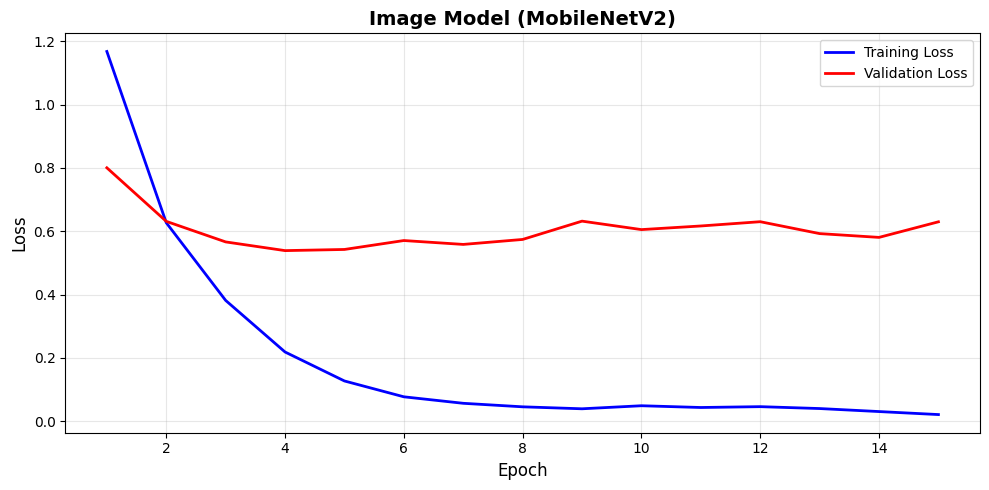

In [ ]:
plot_training_curves(train_losses, test_losses, title="Image Model (MobileNetV2)")

# Text-Only Model (DistilBERT)


## Load DistilBERT


In [17]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
distilbert.eval()
distilbert.to(DEVICE)

TEXT_DIM = 768

## Text Dataset


In [18]:
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=32):
        self.texts = df["filtered_text"].tolist()
        self.labels = df["label_id"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )

        return (
            enc["input_ids"].squeeze(0),  # CPU
            enc["attention_mask"].squeeze(0),  # CPU
            self.labels[idx],
        )

## Text Classifier


In [19]:
class TextModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(TEXT_DIM, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        return self.fc(x)

## Train Text-Only Model


In [ ]:
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "distilbert_text_model.pth")
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_loader = DataLoader(TextDataset(train_df, tokenizer), batch_size=64, shuffle=True)
val_loader = DataLoader(
    TextDataset(val_df, tokenizer),
    batch_size=64,
)

text_model = TextModel(NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(text_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler(DEVICE)

start_epoch = 0

train_losses, test_losses = [], []

if os.path.exists(CHECKPOINT_PATH):
    print("Text model checkpoint found. Loading weights...")

    ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    text_model.load_state_dict(ckpt["model_state_dict"])
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    train_losses = ckpt.get("train_losses", [])
    test_losses = ckpt.get("test_losses", [])
    start_epoch = ckpt["epoch"]
else:
    print("No checkpoint found. Starting training...")

for epoch in range(start_epoch, EPOCHS):
    train_loss, acc = train_epoch(
        text_model, train_loader, optimizer, scaler, criterion, DEVICE, mode="text"
    )
    train_losses.append(train_loss)

    test_loss, val_acc = eval_epoch(
        text_model, val_loader, criterion, DEVICE, mode="text"
    )
    test_losses.append(test_loss)

    print(
        f"[Text] Epoch {epoch+1} | Loss {train_loss:.3f} | Train {acc:.3f} | Val {val_acc:.3f}"
    )

    save_model(
        text_model,
        optimizer,
        epoch + 1,
        NUM_CLASSES,
        le,
        CHECKPOINT_PATH,
        train_losses,
        test_losses,
        text_model_str="distilbert-base-uncased",
    )

No checkpoint found. Starting training...
[Text] Epoch 1 | Loss 1.443 | Train 0.529 | Val 0.607
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 2 | Loss 1.150 | Train 0.615 | Val 0.622
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 3 | Loss 1.067 | Train 0.648 | Val 0.668
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 4 | Loss 1.015 | Train 0.660 | Val 0.669
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 5 | Loss 0.968 | Train 0.675 | Val 0.684
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 6 | Loss 0.939 | Train 0.686 | Val 0.692
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 7 | Loss 0.906 | Train 0.697 | Val 0.703
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 8 | Loss 0.881 | Train 0.709 | Val 0.706
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 9 | Loss 0.855 | Train 0.713 | Val 0.713
Saved model to checkpoints/distilbert_text_model

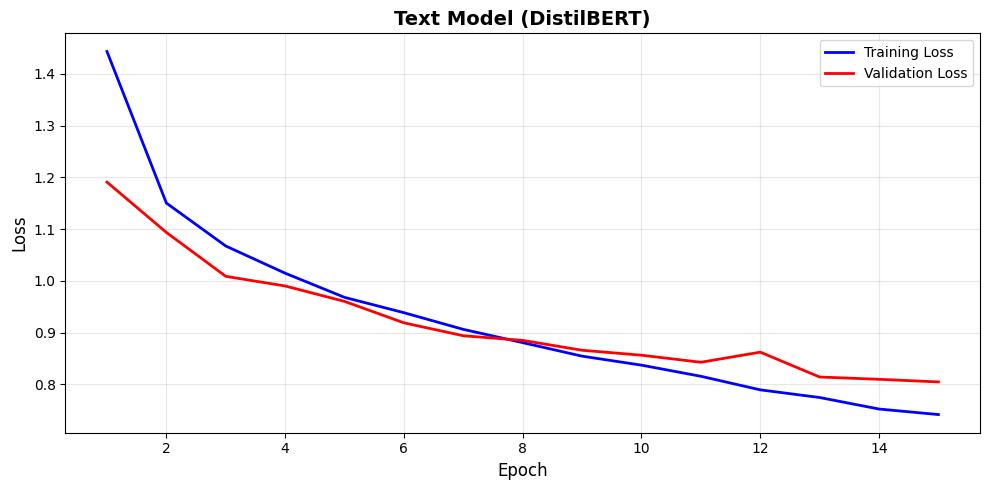

In [ ]:
plot_training_curves(train_losses, test_losses, title="Text Model (DistilBERT)")

# Late Fusion (MobileNetV2 + DistilBERT)


## Multimodal Dataset


In [21]:
class MultiModalDataset(Dataset):
    def __init__(self, df, tokenizer, img_transform=None, max_len=32):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.img_transform = img_transform
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img = Image.open(row["image_path"]).convert("RGB")
        img = img_transform(img)

        enc = tokenizer(
            row["filtered_text"],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )

        return (
            img,
            enc["input_ids"].squeeze(0),
            enc["attention_mask"].squeeze(0),
            row["label_id"],
        )

## Fusion Model


In [ ]:
class FusionModel(nn.Module):
    def __init__(self, image_model, text_model, text_dim=768, num_classes=11):
        super().__init__()

        # Use of the pre-trained image model's backbone (1280-d output)
        self.image_encoder = image_model.backbone

        # Use of the pre-trained text model's classifier (outputs num_classes)
        # Extract features before the final layer
        self.text_encoder = text_model.fc[:-1]
        text_hidden_dim = 256  # Output of the first Linear layer after ReLU+Dropout

        # Fusion classifier (1280 from image + 256 from text)
        self.classifier = nn.Sequential(
            nn.Linear(1280 + text_hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )

    def forward(self, img, input_ids, attention_mask, distilbert):
        # Image features from pre-trained backbone (1280-d)
        img_feat = self.image_encoder(img)

        # Text features from DistilBERT + pre-trained text model layers
        with torch.no_grad():  # Freeze DistilBERT
            text_emb = distilbert(
                input_ids=input_ids, attention_mask=attention_mask
            ).last_hidden_state[:, 0, :]

        # Pass through pre-trained text model layers (768 -> 256)
        text_feat = self.text_encoder(text_emb)

        # Late fusion via concatenation
        fused = torch.cat([img_feat, text_feat], dim=1)

        return self.classifier(fused)

## Train Fusion Model


In [32]:
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "multimodal_fusion_model.pth")

train_loader = DataLoader(
    MultiModalDataset(train_df, tokenizer, img_transform), batch_size=32, shuffle=True
)
val_loader = DataLoader(
    MultiModalDataset(val_df, tokenizer, img_transform), batch_size=32
)

# Freeze pre-trained image model
image_model.eval()
for param in image_model.parameters():
    param.requires_grad = False

# Freeze pre-trained text model
text_model.eval()
for param in text_model.parameters():
    param.requires_grad = False

# Initialize fusion model using both pre-trained models
fusion_model = FusionModel(
    image_model=image_model,
    text_model=text_model,
    text_dim=TEXT_DIM,
    num_classes=NUM_CLASSES,
).to(DEVICE)

optimizer = torch.optim.Adam(fusion_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler(DEVICE)

start_epoch = 0
train_losses, test_losses = [], []

if os.path.exists(CHECKPOINT_PATH):
    print("Fusion model checkpoint found. Loading weights...")
    ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    fusion_model.load_state_dict(ckpt["model_state_dict"])
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    train_losses = ckpt.get("train_losses", [])
    test_losses = ckpt.get("test_losses", [])
    start_epoch = ckpt["epoch"]
else:
    print("No checkpoint found. Starting training...")

for epoch in range(start_epoch, EPOCHS):
    fusion_model.train()
    correct, train_loss = 0, 0

    for img, input_ids, attention_mask, labels in train_loader:
        img, input_ids, attention_mask, labels = (
            img.to(DEVICE),
            input_ids.to(DEVICE),
            attention_mask.to(DEVICE),
            labels.to(DEVICE),
        )
        optimizer.zero_grad()

        with torch.amp.autocast(DEVICE):
            out = fusion_model(img, input_ids, attention_mask, distilbert)
            loss = criterion(out, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
        correct += (out.argmax(1) == labels).sum().item()

    train_acc = correct / len(train_df)
    train_losses.append(train_loss / len(train_loader))

    fusion_model.eval()
    val_correct, test_loss = 0, 0
    with torch.no_grad():
        for img, input_ids, attention_mask, labels in val_loader:
            img, input_ids, attention_mask, labels = (
                img.to(DEVICE),
                input_ids.to(DEVICE),
                attention_mask.to(DEVICE),
                labels.to(DEVICE),
            )
            out = fusion_model(img, input_ids, attention_mask, distilbert)
            loss = criterion(out, labels)
            test_loss += loss.item()
            val_correct += (out.argmax(1) == labels).sum().item()

    test_losses.append(test_loss / len(val_loader))

    print(
        f"[Fusion] Epoch {epoch+1} | Train {correct/len(train_df):.3f} | Val {val_correct/len(val_df):.3f}"
    )

    save_model(
        fusion_model,
        optimizer,
        epoch + 1,
        NUM_CLASSES,
        le,
        CHECKPOINT_PATH,
        train_losses,
        test_losses,
        image_encoder_str="mobilenet_v2",
        text_encoder_str="distilbert-base-uncased",
    )

No checkpoint found. Starting training...
[Fusion] Epoch 1 | Train 0.952 | Val 0.865
Saved model to checkpoints/multimodal_fusion_model.pth
[Fusion] Epoch 2 | Train 0.992 | Val 0.871
Saved model to checkpoints/multimodal_fusion_model.pth
[Fusion] Epoch 3 | Train 0.993 | Val 0.869
Saved model to checkpoints/multimodal_fusion_model.pth
[Fusion] Epoch 4 | Train 0.995 | Val 0.868
Saved model to checkpoints/multimodal_fusion_model.pth
[Fusion] Epoch 5 | Train 0.995 | Val 0.876
Saved model to checkpoints/multimodal_fusion_model.pth
[Fusion] Epoch 6 | Train 0.995 | Val 0.876
Saved model to checkpoints/multimodal_fusion_model.pth
[Fusion] Epoch 7 | Train 0.996 | Val 0.878
Saved model to checkpoints/multimodal_fusion_model.pth
[Fusion] Epoch 8 | Train 0.997 | Val 0.877
Saved model to checkpoints/multimodal_fusion_model.pth
[Fusion] Epoch 9 | Train 0.996 | Val 0.869
Saved model to checkpoints/multimodal_fusion_model.pth
[Fusion] Epoch 10 | Train 0.997 | Val 0.873
Saved model to checkpoints/multi

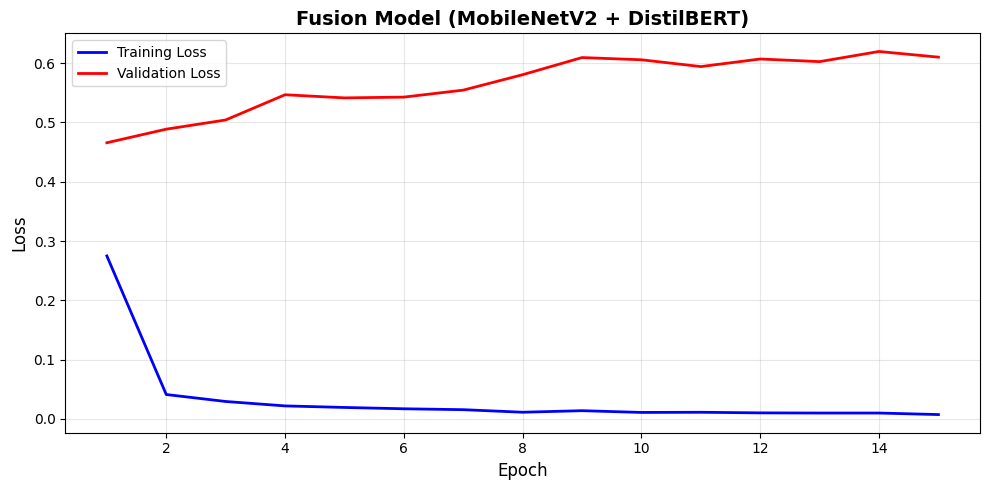

In [33]:
plot_training_curves(train_losses, test_losses, title="Fusion Model (MobileNetV2 + DistilBERT)")